This workbook is running Naive Bayes classifiers to see how well they can handle this sentiment analysis task, in comparison to other models.

I have used Bernoulli NB. I did try Multinomial NB but it failed to handle negative values so I scrapped it. 

If you are unfamiliar, here's a brief explanation of Bernoulli: we model the features as binary variables, typically representing the presence or absence of a feature. It assumes that each feature is conditionally independent given the class label (hence the name 'Naive'). This means that the presence of one feature does not affect the presence of another feature.

It is based on Bayes' theorem which provides a way to update our beliefs about the probability of an event based on new evidence. It's widely used in various fields, including statistics, machine learning, and Bayesian inference.

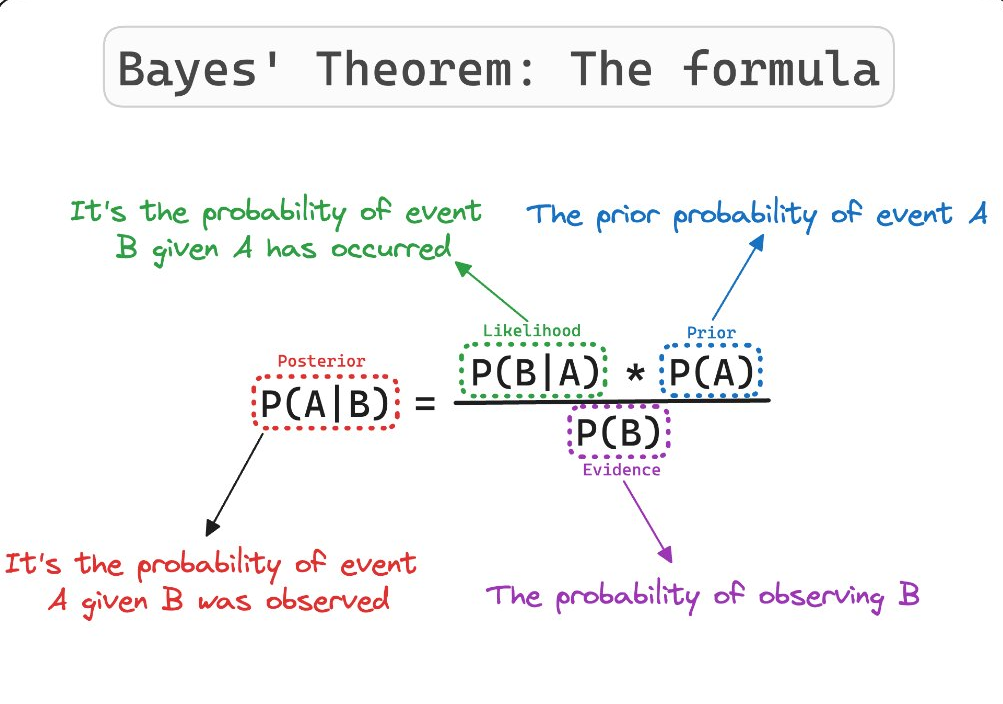

## Setup & Functions

In [1]:
# Imports and Setup
import os
import re
import email
import random
import collections
import itertools
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from string import punctuation
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk import classify
from sklearn import metrics, preprocessing, feature_extraction, linear_model, naive_bayes, ensemble, pipeline, svm, model_selection, decomposition
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import tree, datasets
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# Tell TensorFlow to run all deep learning on GPU:
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Feature extractor and vectorizer, to produce TF-IDF document matrix:
def feature_vectorizer(corpus):
    sa_stop_words = nltk.corpus.stopwords.words('english')
    ''' Create a list of exceptions, as these stopwords may change a sentence's sentiment if removed. '''
    sa_white_list = ['what', 'but', 'if', 'because', 'as', 'until', 'against', 'up', 'down', 'in', 'out',
                    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'why',
                    'how', 'all', 'any', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
                    'same', 'so', 'than', 'too', 'can', 'will', 'just', 'don', 'should']
    ''' Remove stop words except for those specified in the white list. '''
    sa_stop_words = [sw for sw in sa_stop_words if sw not in sa_white_list]
    ''' Instantiate the vectorizer. '''
    count_vectorizer = feature_extraction.text.CountVectorizer(
        lowercase = True,
        tokenizer = nltk.word_tokenize,
        min_df=2, # this means the term frequency must be 2 or higher.
        ngram_range=(1,2),
        stop_words=sa_stop_words
    )
    ''' Run the vectorizer on the body of text ('corpus'). '''
    processed_corpus = count_vectorizer.fit_transform(corpus)
    processed_corpus = feature_extraction.text.TfidfTransformer().fit_transform(processed_corpus)
    return processed_corpus

def data_integrity_check(df, title='', include_non_numeric=True):
    '''Check for nulls, duplicates, etc and perform basic EDA.'''
    results = []
    for col in df:
        result = {
            'Column': col,
            'Null Values': df[col].isnull().sum(),
            'Duplicate Values': df[col].duplicated().sum(),
            'Data Type': df[col].dtype
        }
        if include_non_numeric or df[col].dtype in ['int64', 'float64']:
            result['Unique Values'] = df[col].nunique()
            if df[col].dtype in ['int64', 'float64']:
                result['Mean'] = df[col].mean()
                result['Median'] = df[col].median()
                result['Mode'] = stats.mode(df[col])
                result['Range'] = df[col].max() - df[col].min()
                result['Skew'] = df[col].skew()
                result['Kurtosis'] = df[col].kurtosis()
        if df[col].dtype == 'object':  
            result['Min Text Length'] = df[col].str.len().min()
            result['Max Text Length'] = df[col].str.len().max()
            '''Calculate mean and median text lengths'''
            text_lengths = df[col].str.len()
            result['Mean Text Length'] = np.mean(text_lengths)
            result['Median Text Length'] = np.median(text_lengths)
        results.append(result)
    result_df = pd.DataFrame(results)
    result_df['Source'] = title
    return result_df

# Prints performance metrics for classifiers:
def print_classification_report(y_true, y_pred):
    '''Get a classification report for performance metric inspection.'''
    report = classification_report(y_true, y_pred)
    print(report)

## Classification

In [3]:
# Import dataset from preprocessing outputs:
df_sa = pd.read_csv('lsa_train_output.csv')
print(df_sa.shape)

# Reimport training labels:
df_train = pd.read_csv('sa_train.csv')
print(df_train.shape)

# Training data split
X_training = df_sa
y = df_train[df_train.columns[2:]].values
X_train, X_test, y_train, y_test = train_test_split(X_training, y, test_size = 0.3, random_state=123)

# Classification labels for test data:
df_test_labels = pd.read_csv('sa_test_labels.csv')

# Test data with text only:
df_test_data = pd.read_csv('lsa_test_output.csv')

# Ensure binary nature of test labels:
df_test_labels[df_test_labels == -1] = 1
for col in df_test_labels:
    unique_values = df_test_labels[col].unique()
print(f'Data check: ', unique_values)

(159571, 400)
(159571, 8)
Data check:  [1 0]


In [4]:
# Define common hyperparameter settings for GridSearch:
param_grid_nb = {
    'estimator__alpha': [0.01, 0.05, 0.1, 1.0],
}

# Grid search for Bernoulli Naive Bayes
multi_classifier_bnb = MultiOutputClassifier(BernoulliNB())
grid_search_bnb = GridSearchCV(multi_classifier_bnb, param_grid_nb, n_jobs=10) 
grid_search_bnb.fit(X_train, y_train)
print('Best Bernoulli Naive Bayes Model Performance: {:.4f}'.format(grid_search_bnb.best_score_))
print('Best Bernoulli Naive Bayes Model Parameters:', grid_search_bnb.best_params_)

Best Bernoulli Naive Bayes Model Performance: 0.8686
Best Bernoulli Naive Bayes Model Parameters: {'estimator__alpha': 0.01}


In [5]:
# Print classes with matching number for reference:
class_mapping = {
        0: 'Toxic',
        1: 'Severely Toxic',
        2: 'Obscene',
        3: 'Threat',
        4: 'Insult',
        5: 'Identity Hate'
        }

# Instantiate Bernoulli Naive Bayes with best parameters:
best_bnb_params = grid_search_bnb.best_params_
alpha = best_bnb_params['estimator__alpha']
best_bnb_classifier = BernoulliNB(alpha=alpha)
best_multi_classifier_bnb = MultiOutputClassifier(best_bnb_classifier)
best_multi_classifier_bnb.fit(X_train, y_train)
y_pred_bnb = best_multi_classifier_bnb.predict(X_test)
print("Classification Report for Bernoulli Naive Bayes Training Data:")
print(classification_report(y_test, y_pred_bnb, target_names=class_mapping.values()))

Classification Report for Bernoulli Naive Bayes Training Data:
                precision    recall  f1-score   support

         Toxic       0.55      0.48      0.51      4478
Severely Toxic       0.29      0.60      0.39       476
       Obscene       0.64      0.51      0.57      2499
        Threat       0.10      0.47      0.17       139
        Insult       0.51      0.49      0.50      2321
 Identity Hate       0.18      0.40      0.25       426

     micro avg       0.47      0.49      0.48     10339
     macro avg       0.38      0.49      0.40     10339
  weighted avg       0.53      0.49      0.50     10339
   samples avg       0.04      0.04      0.04     10339



Let's run it on the test dataset now.

In [6]:
# Input data/feature split:
X_testing = df_test_data
y_true = df_test_labels[df_test_labels.columns[1:]].values

# Run LR classifier on test dataset:
y_pred_bnb = best_multi_classifier_bnb.predict(X_testing)
print("Classification Report for Bernoulli Naive Bayes Test Data:")
print(classification_report(y_true, y_pred_bnb, target_names=class_mapping.values()))

Classification Report for Bernoulli Naive Bayes Test Data:
                precision    recall  f1-score   support

         Toxic       0.58      0.03      0.06     95276
Severely Toxic       0.55      0.00      0.00     89553
       Obscene       0.56      0.01      0.03     92877
        Threat       0.47      0.00      0.00     89397
        Insult       0.55      0.01      0.02     92613
 Identity Hate       0.55      0.00      0.00     89898

     micro avg       0.57      0.01      0.02    549614
     macro avg       0.54      0.01      0.02    549614
  weighted avg       0.54      0.01      0.02    549614
   samples avg       0.02      0.01      0.01    549614



In [7]:
# Let's check out some confusion matrices:
cm_bnb = multilabel_confusion_matrix(y_true, y_pred_bnb)

# Printing confusion matrices for Bernoulli Naive Bayes
print("\nConfusion Matrix for Bernoulli Naive Bayes:")
for i, cm in enumerate(cm_bnb):
    class_name = class_mapping[i]
    print(f"\nClass {class_name}:\n{cm}")


Confusion Matrix for Bernoulli Naive Bayes:

Class Toxic:
[[55854  2034]
 [92500  2776]]

Class Severely Toxic:
[[63498   113]
 [89417   136]]

Class Obscene:
[[59338   949]
 [91648  1229]]

Class Threat:
[[63757    10]
 [89388     9]]

Class Insult:
[[59675   876]
 [91563  1050]]

Class Identity Hate:
[[63207    59]
 [89827    71]]


To help with interpretation: https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

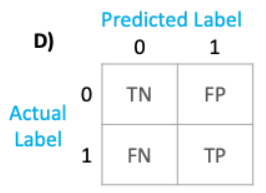

Confusion Matrix shows huge class imbalance between positives and negatives. Recall is extremely low, 